#### Leitura dos arquivos sobre o clima

Arquivos baixados do site [inmet](https://portal.inmet.gov.br/dadoshistoricos) (arquivos de 2022)

In [1]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import isnan

REMOVE_COLUMNS_REGION = ["CODIGO (WMO):", "DATA DE FUNDACAO:"]
GET_COLUMNS_CLIMATE = [
    "Data",
    "Hora UTC",
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",
    "VENTO, VELOCIDADE HORARIA (m/s)",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
    "RADIACAO GLOBAL (Kj/m²)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
]

%matplotlib inline

In [2]:
climate_dir = "./data/2022"
list_df_station = []
list_df_climate = []

count = 0

for file_name in os.listdir(climate_dir):
    # Nossa tabela fato, utiliza o nome da UF, latitude, longitude e altitude
    df_station = pd.read_csv(
        f"{climate_dir}/{file_name}",
        delimiter=";",
        encoding="Windows 1252",
        nrows=7,
    ).set_index("REGIAO:").transpose().reset_index(drop=True)

    df_station = df_station.drop(columns=REMOVE_COLUMNS_REGION)

    df_station = df_station.rename(columns={"UF:":"UF",
                                            "LATITUDE:":"latitude",
                                            "LONGITUDE:":"longitude",
                                            "ALTITUDE:":"altitude",
                                            "ESTACAO:": "cidade"})


    df_climate = pd.read_csv(
        f"{climate_dir}/{file_name}",
        delimiter=";",
        encoding="Windows 1252",
        skiprows=8,
    ).dropna(how="all", subset=GET_COLUMNS_CLIMATE[2:]).get(GET_COLUMNS_CLIMATE)

    df_climate = df_climate.rename_axis("id")

    df_climate = df_climate.rename(columns={"CODIGO (WMO)": "id",
                                  "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precipTotalHorario",
                                  "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "tempAr",
                                  "VENTO, VELOCIDADE HORARIA (m/s)": "ventoVeloHoraria",
                                  "RADIACAO GLOBAL (Kj/m²)": "radGlobal",
                                  "UMIDADE RELATIVA DO AR, HORARIA (%)": "umidRelAr"})

    #Adicionando id da FK
    df_climate["id_regiao"] = count
    count = count+1



    list_df_station.append(df_station)
    list_df_climate.append(df_climate)

In [5]:
# Criar timestamp usando as colunas 'Data' e 'Hora UTC'
def create_timestamp(row):
    return dt.datetime.strptime(f"{row['Data']} {row['Hora UTC']}", "%Y/%m/%d %H%M UTC")

df_all_climate["timestamp"] = df_all_climate.apply(create_timestamp, axis=1)
df_all_climate = df_all_climate.drop(["Data", "Hora UTC"], axis=1)

In [6]:
# Converter as colunas relevantes para tipo numérico
numeric_columns = ['precipTotalHorario', 'ventoVeloHoraria', 'tempAr', 'radGlobal', 'umidRelAr']

for column in numeric_columns:
    df_all_climate[column] = pd.to_numeric(
        df_all_climate[column].apply(lambda v: str(v).replace(',', '.') if not type(v) == float else v),
        errors='raise'
    )

In [7]:
df_all_climate = df_all_climate.rename_axis("id")
df_all_climate.to_csv("./data/fato_dados_meteorologicos.csv", sep=";")
df_all_climate

,precipTotalHorario,ventoVeloHoraria,tempAr,radGlobal,umidRelAr,id_regiao,timestamp
id,,,,,,,
0,0.0,0.8,NaN,NaN,NaN,0,2022-03-14 15:00:00
1,0.0,1.0,NaN,0.0,NaN,0,2022-03-14 16:00:00
2,0.0,1.0,NaN,0.0,NaN,0,2022-03-14 17:00:00
3,0.0,1.9,NaN,0.0,NaN,0,2022-03-14 18:00:00
4,4.8,6.5,NaN,0.0,NaN,0,2022-03-14 19:00:00
...,...,...,...,...,...,...,...
3437918,0.0,2.0,25.1,275.6,54.0,566,2022-12-31 19:00:00
3437919,0.0,1.6,22.9,11.6,62.0,566,2022-12-31 20:00:00
3437920,0.0,1.7,20.5,NaN,76.0,566,2022-12-31 21:00:00


In [8]:
df_grouped_climate = df_all_climate.set_index('timestamp')
df_grouped_climate = df_grouped_climate.groupby("timestamp").mean()
df_grouped_climate

,precipTotalHorario,ventoVeloHoraria,tempAr,radGlobal,umidRelAr,id_regiao
timestamp,,,,,,
2022-01-01 00:00:00,0.511263,1.589073,22.695031,5.402564,82.640264,283.898148
2022-01-01 01:00:00,0.325517,1.587919,22.302821,56.254762,84.762542,283.258567
2022-01-01 02:00:00,0.370345,1.539465,21.915265,131.682609,86.194631,286.095975
2022-01-01 03:00:00,0.242282,1.503560,21.712195,184.556522,86.795380,285.030211
2022-01-01 04:00:00,0.173559,1.507516,21.410154,104.776744,88.143813,285.770642
...,...,...,...,...,...,...
2022-12-31 19:00:00,0.242081,2.353226,28.474510,1715.009051,59.671875,279.801296
2022-12-31 20:00:00,0.281651,2.224299,27.711038,1124.687248,62.709751,279.857768
2022-12-31 21:00:00,0.234483,1.906557,26.596018,555.022748,67.623288,279.743421


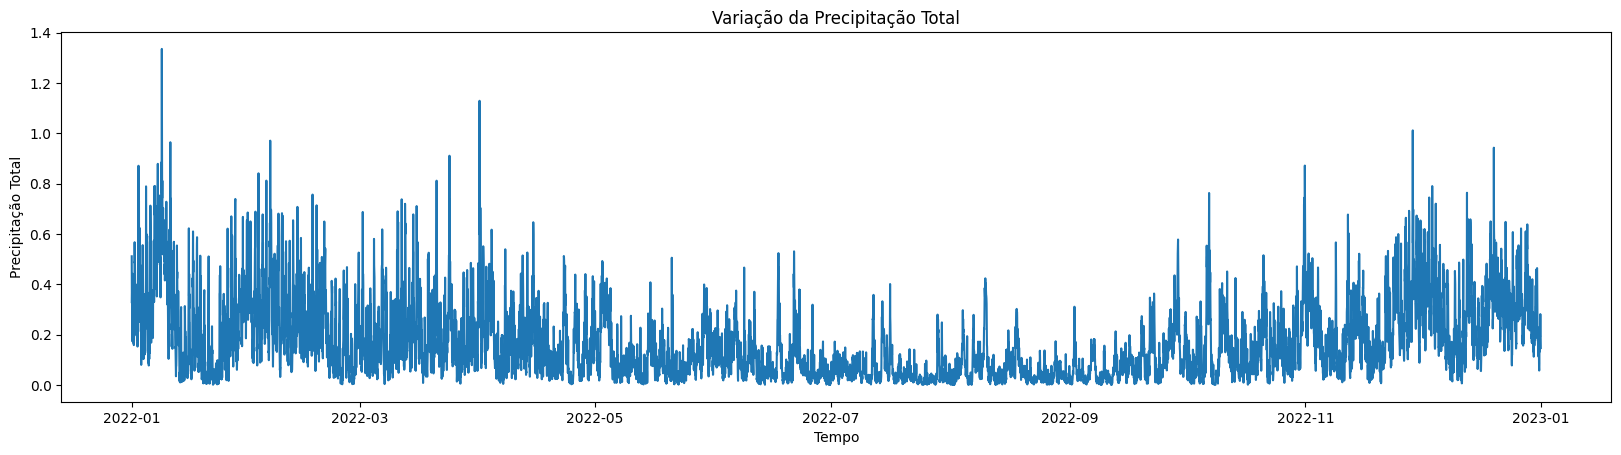

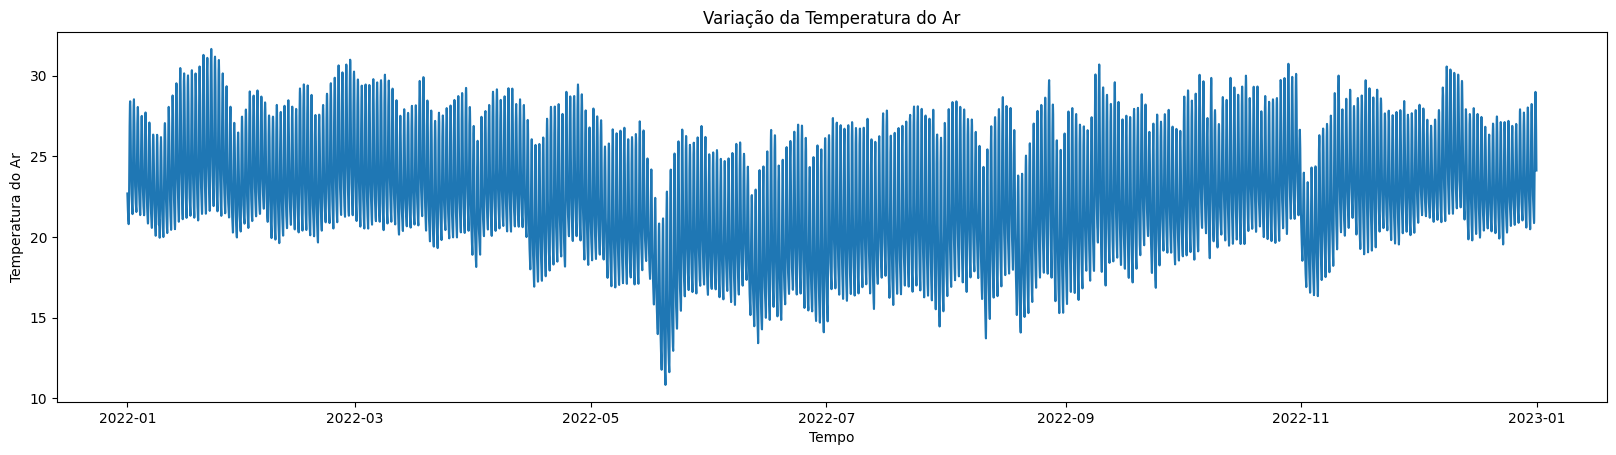

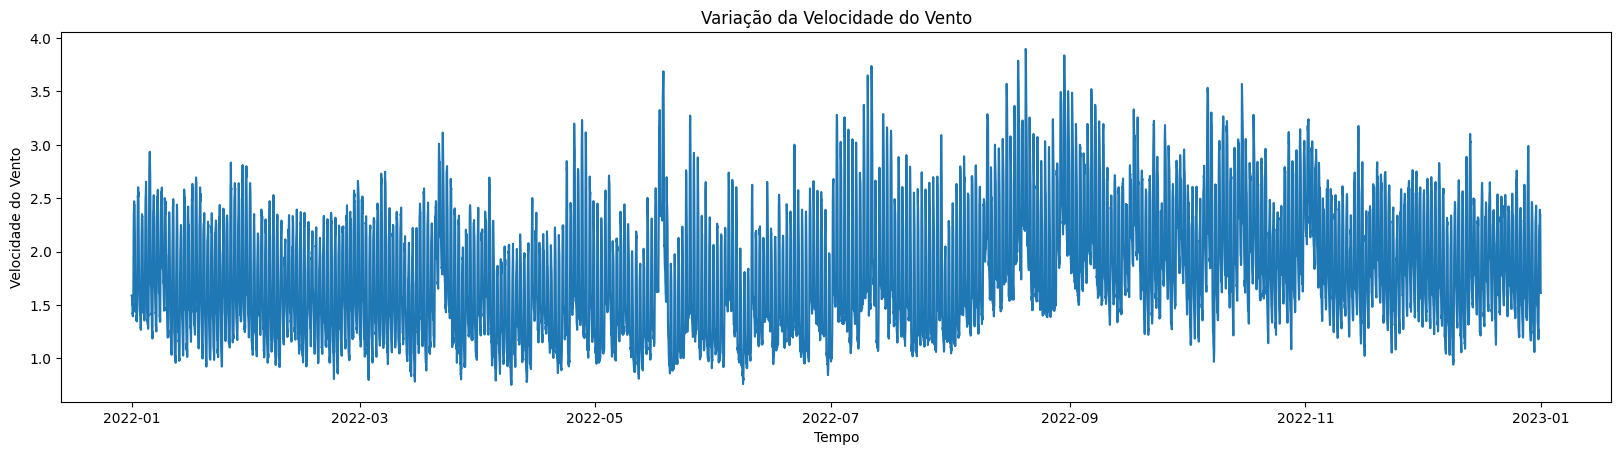

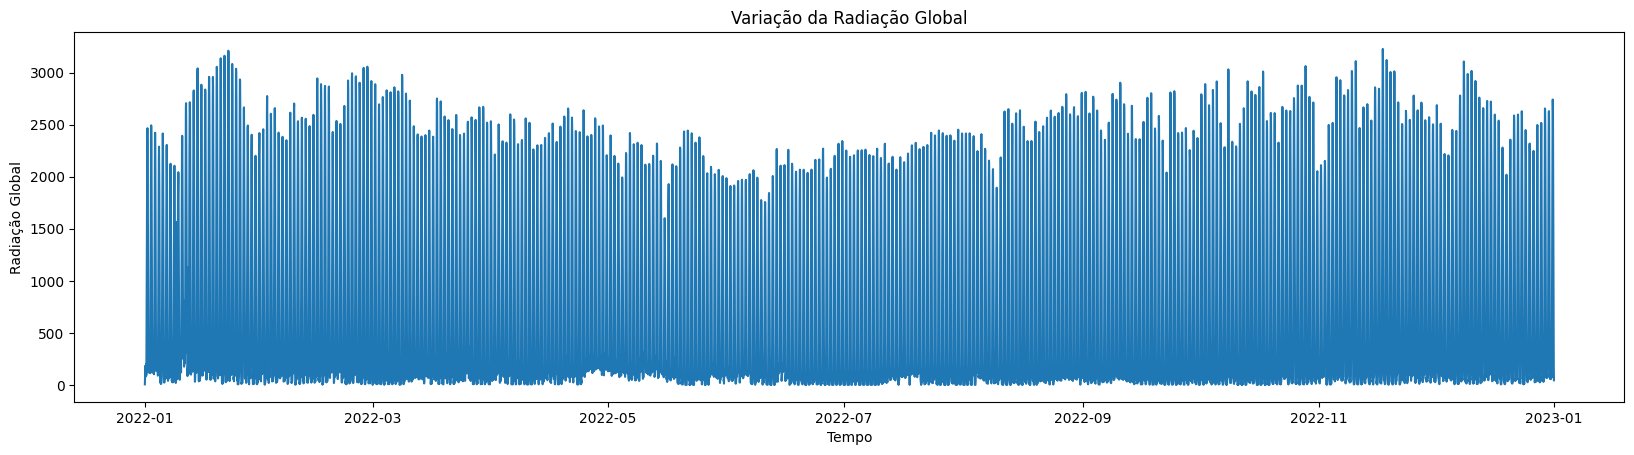

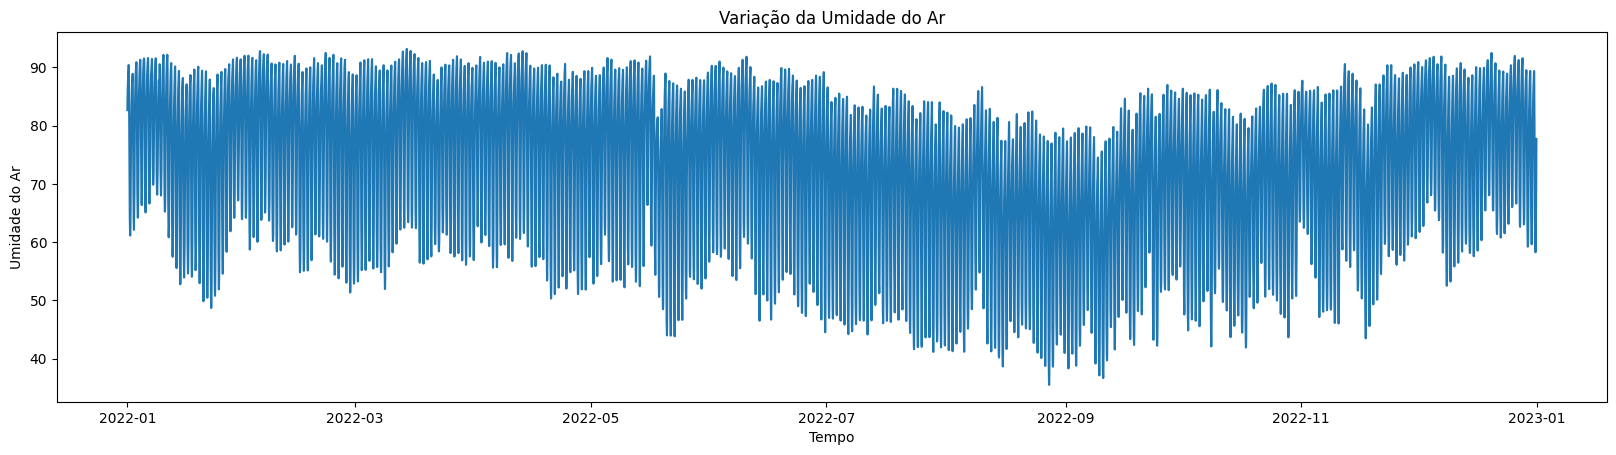

In [9]:
# Criar gráfico de linhas para a precipitaçãoTotal
plt.figure(figsize=(20, 4.8))
plt.plot(df_grouped_climate.index, df_grouped_climate['precipTotalHorario'])
plt.xlabel('Tempo')
plt.ylabel('Precipitação Total')
plt.title('Variação da Precipitação Total')
plt.show()

# Criar gráfico de linhas para a temperaturaAr
plt.figure(figsize=(20, 4.8))
plt.plot(df_grouped_climate.index, df_grouped_climate['tempAr'])
plt.xlabel('Tempo')
plt.ylabel('Temperatura do Ar')
plt.title('Variação da Temperatura do Ar')
plt.show()

# Criar gráfico de linhas para a velocidadeVento
plt.figure(figsize=(20, 4.8))
plt.plot(df_grouped_climate.index, df_grouped_climate['ventoVeloHoraria'])
plt.xlabel('Tempo')
plt.ylabel('Velocidade do Vento')
plt.title('Variação da Velocidade do Vento')
plt.show()

# Criar gráfico de linhas para a radiaçãoGlobal
plt.figure(figsize=(20, 4.8))
plt.plot(df_grouped_climate.index, df_grouped_climate['radGlobal'])
plt.xlabel('Tempo')
plt.ylabel('Radiação Global')
plt.title('Variação da Radiação Global')
plt.show()

# Criar gráfico de linhas para a humidadeAr
plt.figure(figsize=(20, 4.8))
plt.plot(df_grouped_climate.index, df_grouped_climate['umidRelAr'])
plt.xlabel('Tempo')
plt.ylabel('Umidade do Ar')
plt.title('Variação da Umidade do Ar')
plt.show()

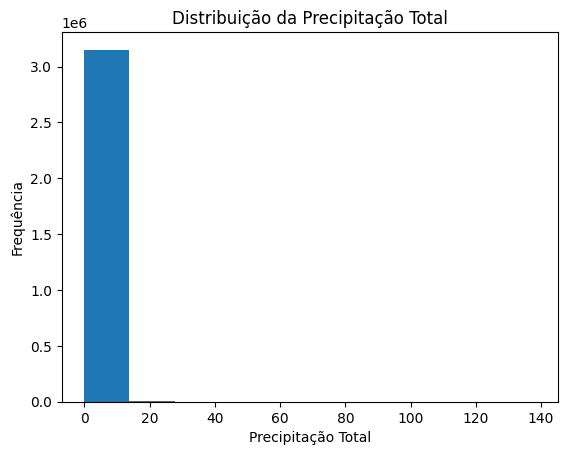

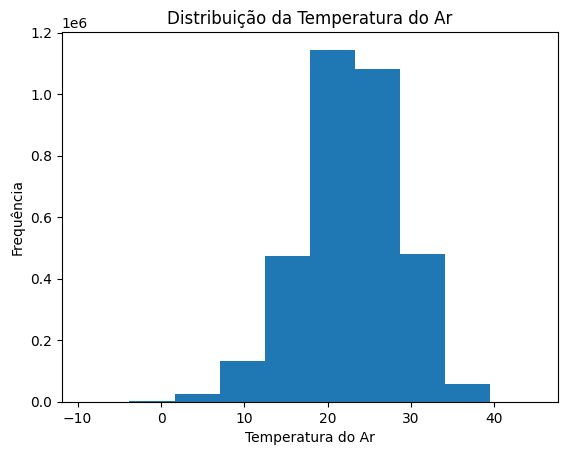

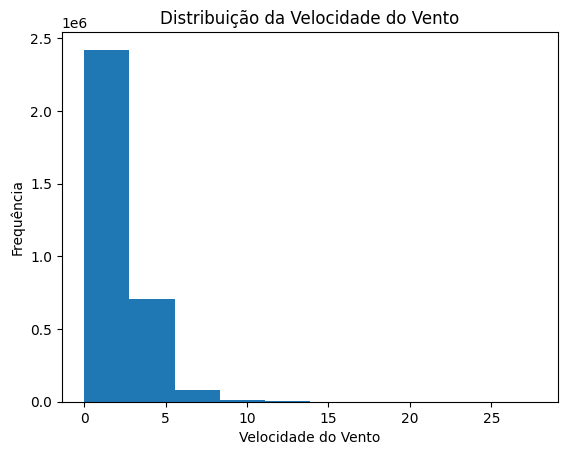

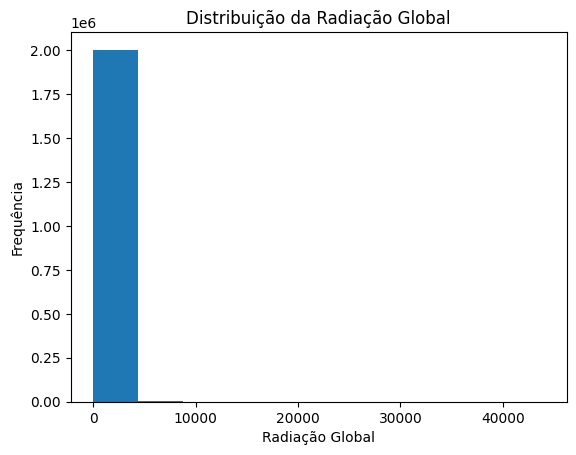

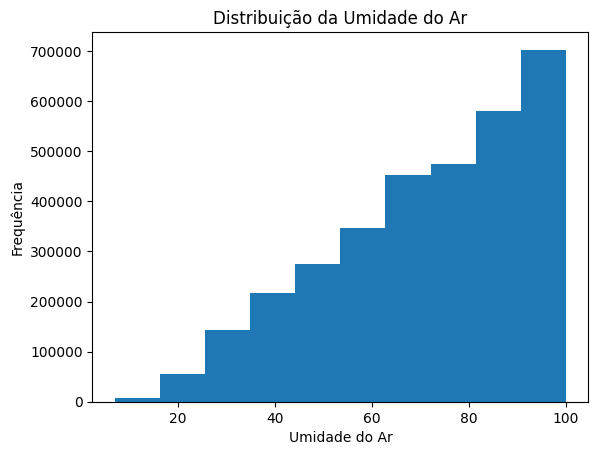

In [10]:
# Criar histograma para a precipitaçãoTotal
plt.hist(df_all_climate['precipTotalHorario'], bins=10)
plt.xlabel('Precipitação Total')
plt.ylabel('Frequência')
plt.title('Distribuição da Precipitação Total')
plt.show()

# Criar histograma para a temperaturaAr
plt.hist(df_all_climate['tempAr'], bins=10)
plt.xlabel('Temperatura do Ar')
plt.ylabel('Frequência')
plt.title('Distribuição da Temperatura do Ar')
plt.show()

# Criar histograma para a velocidadeVento
plt.hist(df_all_climate['ventoVeloHoraria'], bins=10)
plt.xlabel('Velocidade do Vento')
plt.ylabel('Frequência')
plt.title('Distribuição da Velocidade do Vento')
plt.show()

# Criar histograma para a radiaçãoGlobal
plt.hist(df_all_climate['radGlobal'], bins=10)
plt.xlabel('Radiação Global')
plt.ylabel('Frequência')
plt.title('Distribuição da Radiação Global')
plt.show()

# Criar histograma para a humidadeAr
plt.hist(df_all_climate['umidRelAr'], bins=10)
plt.xlabel('Umidade do Ar')
plt.ylabel('Frequência')
plt.title('Distribuição da Umidade do Ar')
plt.show()